In [1]:
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_palette("pastel")

Top CS programs per US News & World Reports: 
1. Carnegie Mellon University
2. Massachusetts Institute of Technology
3. Stanford University
4. University of California--Berkeley
5. University of Illinois--Urbana-Champaign
6. Cornell University
7. University of Washington
8. Georgia Institute of Technology
9. Princeton University
10. University of Texas--Austin

In [2]:
random.seed(12345)
random.randrange(1,11)

7

## Goal 1: data on non-academic experiences

7 = Washington University

In [3]:
# load the linkedin data
path = r"C:\Users\tlebr\Google Drive\Personal\codingassignment\data\linkedincsvs/"
df_ls = []
for f in os.listdir(path):
    df = pd.read_csv(f"{path}{f}", encoding="utf-8", )
    df = df.rename({"Unnamed: 0": "org_ind"}, axis=1)
    df_ls.append(df)
maindf = pd.concat(df_ls, ignore_index=True)

In [4]:
# Clean the data
maindf.date_end_asdt = pd.to_datetime(maindf.date_end_asdt, errors='coerce')
maindf.date_start_asdt = pd.to_datetime(maindf.date_start_asdt, errors='coerce')
maindf['duration_months'] = maindf.date_end_asdt - maindf.date_start_asdt
maindf.duration_months = maindf.duration_months.astype('timedelta64[M]')

In [5]:
# Display experiences and organizations to help develop keyword filters for professional experiences on 
# Linkedin that actually were still part of academia
 
pd.options.display.max_rows = None
print(maindf[maindf.type == "experience"].title.value_counts())
pd.options.display.max_rows = 10
# use results to determine which keywords are needed to filter out academic titles


Assistant Professor                                                                                       17
Professor                                                                                                 16
Associate Professor                                                                                       12
Research Intern                                                                                           12
Title Associate Professor                                                                                 12
Title Assistant Professor                                                                                  8
Postdoctoral Researcher                                                                                    6
Software Engineer                                                                                          6
Research Assistant                                                                                         6
Software Engineerin

In [6]:
pd.options.display.max_rows = None
print(maindf[maindf.type == "experience"].organization.value_counts())
pd.options.display.max_rows = 10
# use results to determine which keywords are needed to filter out academic organizations

University of Washington                                                                          71
Microsoft                                                                                         10
Google                                                                                             9
University of Washington Full-time                                                                 8
UC Berkeley                                                                                        7
MIT                                                                                                6
University of Illinois at Urbana-Champaign                                                         5
Stanford University                                                                                5
Carnegie Mellon University                                                                         5
Microsoft Research                                                                         

In [7]:
def isacademic(df):
    """Returns True if position is academic"""
    academictitles = "professor|student|lecturer|faculty|candidate|phd|bachelor|teaching"
    academicorgs = "university|school|univ|department|mit|berkeley|institute of technology|carnegie mellon|uc san diego|caltech"
    x = df.title.str.lower().str.contains(academictitles)
    y = df.organization.str.lower().str.contains(academicorgs)
    return (x | y) 


In [8]:
maindf["isacademic"] = isacademic(maindf)
# any educational experience classified as academic
maindf["isacademic"] = np.where(maindf.type == "education", True, maindf.isacademic)
# [print(row) for row in maindf[~maindf.isacademic][["title", "organization"]].itertuples()];
# pd.options.display.max_rows = 10

In [9]:
# dataframe with all non-academic experiences (including those before graduation)
# save to data/nonacademic.csv
nonacademic = maindf[~maindf.isacademic]
nonacademic.date_end_asdt = nonacademic.date_end_asdt.dt.date.astype(str)
nonacademic.date_end_asdt = nonacademic.date_start_asdt.dt.date.astype(str)
nonacademic = nonacademic[nonacademic["date_end_asdt"] >= "2000-01-01"]
nonacademic = nonacademic.drop(["org_ind", "degree", "field_of_study", "degree", "type", "isacademic", "linkedin"], axis=1)
nonacademic.to_csv("../data/nonacademic.csv", index=False)

C:\Users\tlebr\envs\codingassignment\lib\site-packages\pandas\core\generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Goal 3: trends in publications

In [10]:
# Data on time since graduation in order to filter experiences that were before graduation
for name, group in maindf.groupby("id"):
    grad = group[group['type'] == "education"].date_end_asdt.max()
    group["graduation"]  = grad
    group["since_graduation"] = (datetime.today() - grad) / np.timedelta64(1, 'Y') # convert timedelta to years
    for i, value in group.iterrows():
        maindf.at[i, "graduation"] = value.graduation
        maindf.at[i, "since_graduation"] = value.since_graduation

In [11]:
# Filter non-academic activities that happen before latest graduation (think college internships)
for name, group in maindf.groupby("id"):
    latest_edu = group[group["type"] == "education"].date_end_asdt.max()
    group["isacademic"] = np.where(group.date_start_asdt < latest_edu, True, group.isacademic)
    # there is a better way to use groupby to mutate maindf but this works for now
    for i, value in group.iterrows():
        maindf.at[i, "isacademic"] = value.isacademic


In [12]:
# Get dates on their first non-academic experiences
for name, group in maindf.groupby("id"):
    group['first_xp_start'] = group[group['isacademic'] == False].date_start_asdt.min()
    group['first_xp_end'] = group[group['isacademic'] == False].date_end_asdt.min()
    for i, value in group.iterrows():
        maindf.at[i, "first_xp_start"] = value.first_xp_start
        maindf.at[i, "first_xp_end"] = value.first_xp_end


In [13]:
# sanity check
maindf

,org_ind,linkedin_url,filename,title,organization,fulltime,date_start,date_start_asdt,date_end,date_end_asdt,...,degree,field_of_study,id,linkedin,duration_months,isacademic,graduation,since_graduation,first_xp_start,first_xp_end
0,0,https://www.linkedin.com/in/adriana-schulz-13b...,Adriana Schulz _ LinkedIn,Assistant Professor,Paul G. Allen School of Computer Science & Eng...,Full-time,Sep 2018,2018-09-10,Present,2021-08-10 07:35:44.280163,...,NaN,NaN,64,https://www.linkedin.com/in/adriana-schulz-13b...,35.0,True,2016-08-10,5.003653,NaT,NaT
1,1,https://www.linkedin.com/in/adriana-schulz-13b...,Adriana Schulz _ LinkedIn,PhD Student and Research Assistant,MIT,Full-time,Sep 2011,2011-09-10,Sep 2018,2018-09-10 00:00:00.000000,...,NaN,NaN,64,https://www.linkedin.com/in/adriana-schulz-13b...,84.0,True,2016-08-10,5.003653,NaT,NaT
2,2,https://www.linkedin.com/in/adriana-schulz-13b...,Adriana Schulz _ LinkedIn,Doctor of Philosophy (PhD) in Computer Science,Massachusetts Institute of Technology,NaN,2011,2011-08-10,2016,2016-08-10 00:00:00.000000,...,Doctor of Philosophy (PhD),Computer Science,64,https://www.linkedin.com/in/adriana-schulz-13b...,60.0,True,2016-08-10,5.003653,NaT,NaT
3,3,https://www.linkedin.com/in/adriana-schulz-13b...,Adriana Schulz _ LinkedIn,Master of Science (M.Sc.) in Applied Mathematics,IMPA,NaN,2009,2009-08-10,2011,2011-08-10 00:00:00.000000,...,Master of Science (M.Sc.),Applied Mathematics,64,https://www.linkedin.com/in/adriana-schulz-13b...,23.0,True,2016-08-10,5.003653,NaT,NaT
4,4,https://www.linkedin.com/in/adriana-schulz-13b...,Adriana Schulz _ LinkedIn,Bachelor's degree in Electrical and Electronic...,Universidade Federal do Rio de Janeiro,NaN,2004,2004-08-10,2009,2009-08-10 00:00:00.000000,...,Bachelor's degree,Electrical and Electronics En= gineering,64,https://www.linkedin.com/in/adriana-schulz-13b...,59.0,True,2016-08-10,5.003653,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,2,https://www.linkedin.com/in/zoran-popovic-3628...,Zoran Popovic _ LinkedIn,Title Professor,University of Washington,NaN,Oct 2010,2010-10-10,Present,2021-08-10 07:36:02.888570,...,NaN,NaN,54,https://www.linkedin.com/in/zoran-popovic-3628...,130.0,True,1999-08-10,22.006055,2003-08-10,2005-08-10
422,3,https://www.linkedin.com/in/zoran-popovic-3628...,Zoran Popovic _ LinkedIn,Title Associate Professor,University of Washington,NaN,Oct 2010,2010-10-10,Present,2021-08-10 07:36:02.893567,...,NaN,NaN,54,https://www.linkedin.com/in/zoran-popovic-3628...,130.0,True,1999-08-10,22.006055,2003-08-10,2005-08-10
423,4,https://www.linkedin.com/in/zoran-popovic-3628...,Zoran Popovic _ LinkedIn,consultant,Electronic Arts,NaN,2003,2003-08-10,2005,2005-08-10 00:00:00.000000,...,NaN,NaN,54,https://www.linkedin.com/in/zoran-popovic-3628...,24.0,False,1999-08-10,22.006055,2003-08-10,2005-08-10
424,5,https://www.linkedin.com/in/zoran-popovic-3628...,Zoran Popovic _ LinkedIn,PhD in Computer Science,Carnegie Mellon University,NaN,1991,1991-08-10,1999,1999-08-10 00:00:00.000000,...,PhD,Computer Science,54,https://www.linkedin.com/in/zoran-popovic-3628...,96.0,True,1999-08-10,22.006055,2003-08-10,2005-08-10


In [14]:
# Load google scholar data
path = r"C:/Users/tlebr/Google Drive/Personal/codingassignment/data/googescholarscsvs/"
df_ls = []
for f in os.listdir(path):
    df = pd.read_csv(f"{path}{f}", encoding="utf-8", ) 
    df = df.rename({"Unnamed: 0": "org_ind"}, axis=1)
    df_ls.append(df)
gsdf = pd.concat(df_ls, ignore_index=True)
gsdf = gsdf[gsdf.year > 2000]

scholarmeta = pd.read_csv(r"C:\Users\tlebr\Google Drive\Personal\codingassignment\data\googlescholarmeta.csv", encoding="utf-8")
scholarmeta = scholarmeta.merge(
    maindf[[
        "id", 
        "since_graduation",
        "graduation",
        "first_xp_start",
        'first_xp_end',
    ]].groupby("id").max(), 
    on="id", 
    how="left",
)
scholarmeta.first_xp_start = pd.to_datetime(scholarmeta.first_xp_start).dt.year
scholarmeta.first_xp_end = pd.to_datetime(scholarmeta.first_xp_end).dt.year

# use this code to filter to faculty with graduation datas (47 in total )
# scholarmeta = scholarmeta[scholarmeta.graduation.notna()]

facultywnonaca = nonacademic.id.unique() 
scholarmeta["nonacademic"] = scholarmeta.id.isin(facultywnonaca)
gsdf["nonacademic"] = gsdf.id.isin(facultywnonaca)

scholarmeta = scholarmeta.set_index("id")

In [15]:
# non-academic experiences with pre-graduation experiences filtered
nonacademic2 = maindf[~maindf.isacademic]
nonacademic2["year_start"] = pd.to_datetime(nonacademic2.date_start_asdt).dt.year 
nonacademic2["year_end"] = pd.to_datetime(nonacademic2.date_end_asdt).dt.year 
nonacademic2 = nonacademic2[nonacademic2["date_end_asdt"] >= "2000-01-01"]
nonacademic2 = nonacademic2.drop(["linkedin_url", "filename", "linkedin"], axis=1)
months = nonacademic2[((nonacademic2["date_end"] != "Present") & (nonacademic2.duration_months < 100))].duration_months.mean()
print(f"Average duration of a nonacademic professional experience is {round(months)} months")


Average duration of a nonacademic professional experience is 24 months


C:\Users\tlebr\AppData\Local\Temp/ipykernel_3340/297908318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonacademic2["year_start"] = pd.to_datetime(nonacademic2.date_start_asdt).dt.year
C:\Users\tlebr\AppData\Local\Temp/ipykernel_3340/297908318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonacademic2["year_end"] = pd.to_datetime(nonacademic2.date_end_asdt).dt.year


In [16]:
# Test if scholars with non-academic experience are younger or older on average
print(f"Years since graduation:")
print(f"Faculty with non-academic experience: {scholarmeta[scholarmeta['nonacademic']].since_graduation.mean()}")
print(f"Faculty without non-academic experience: {scholarmeta[~scholarmeta['nonacademic']].since_graduation.mean()}")

Years since graduation:
Faculty with non-academic experience: 12.91107030169857
Faculty without non-academic experience: 21.671665431495548


This result suggests that younger faculty are the ones taking up non-academic positions, although this could be due to the fact that older faculty do not list their non-academic affiliations on Linkedin. 

In [22]:
cols = ['citations_total', 'citations_2016', 'h-index_total', 'h-index_2016', 
'i10-index_total', 'i10-index_2016', '2010', '2011', '2012', '2013', '2014', 
'2015', '2016', '2017', '2018', '2019', '2020', '2021',]



In [23]:
# PROFESSORS WITH NON-ACADEMIC EXPERIENCE
scholarmeta[scholarmeta["nonacademic"]][cols].describe()

,citations_total,citations_2016,h-index_total,h-index_2016,i10-index_total,i10-index_2016,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,27.000000,29.000000,30.000000,33.000000,34.000000,34.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,15153.083333,8210.888889,45.694444,35.416667,100.500000,80.666667,610.888889,651.275862,731.666667,778.878788,845.323529,942.911765,1016.055556,1114.444444,1324.833333,1615.527778,1933.194444,1184.805556
std,17083.892754,9559.424465,25.938190,16.491340,80.661019,56.863244,798.178086,783.566475,845.378199,925.668737,973.559751,1005.990251,1091.360067,1077.328851,1401.375681,2157.756248,2844.625788,1820.574239
min,650.000000,533.000000,12.000000,12.000000,13.000000,13.000000,18.000000,22.000000,9.000000,10.000000,9.000000,15.000000,13.000000,38.000000,85.000000,126.000000,89.000000,87.000000
25%,3124.500000,2200.000000,24.750000,22.750000,38.500000,34.500000,84.500000,89.000000,136.000000,108.000000,106.000000,155.750000,189.500000,278.500000,382.500000,445.500000,512.000000,385.750000
50%,9079.000000,5544.000000,37.000000,33.500000,69.000000,62.000000,426.000000,482.000000,559.500000,520.000000,600.000000,774.000000,799.000000,895.500000,1005.500000,1079.000000,1299.500000,738.500000
75%,19938.500000,11919.750000,62.750000,48.250000,147.750000,118.750000,725.500000,872.000000,1028.500000,1196.000000,1218.250000,1317.250000,1483.500000,1587.000000,1691.250000,2019.000000,2218.500000,1296.750000
max,74237.000000,51408.000000,114.000000,78.000000,331.000000,220.000000,3638.000000,3544.000000,3936.000000,4472.000000,4711.000000,4697.000000,5054.000000,4702.000000,6797.000000,12512.000000,16783.000000,10813.000000


In [86]:
# NO NON-ACADEMIC EXPERIENCE
scholarmeta[~scholarmeta["nonacademic"]][cols].describe()

,citations_total,citations_2016,h-index_total,h-index_2016,i10-index_total,i10-index_2016,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,20.000000,22.000000,24.000000,25.000000,25.00000,25.00000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000
mean,12512.00000,5330.960000,41.200000,28.480000,83.120000,57.240000,598.750000,592.590909,572.333333,591.600000,642.68000,676.24000,741.280000,795.800000,872.84000,957.840000,1149.720000,804.600000
std,11225.86981,4991.503852,23.673121,15.253743,66.177363,42.785589,569.229015,605.951016,632.241882,678.596898,710.85774,721.20416,758.265813,778.004981,840.49701,905.604526,1136.081039,901.320744
min,418.00000,169.000000,7.000000,7.000000,7.000000,5.000000,5.000000,8.000000,4.000000,3.000000,2.00000,7.00000,13.000000,30.000000,36.00000,29.000000,33.000000,23.000000
25%,2396.00000,1748.000000,22.000000,19.000000,31.000000,24.000000,161.250000,135.500000,70.750000,30.000000,66.00000,113.00000,133.000000,225.000000,238.00000,290.000000,258.000000,184.000000
50%,8151.00000,2973.000000,39.000000,27.000000,80.000000,43.000000,386.000000,414.500000,396.500000,395.000000,442.00000,437.00000,531.000000,557.000000,589.00000,596.000000,894.000000,611.000000
75%,20504.00000,7990.000000,59.000000,40.000000,109.000000,80.000000,869.250000,851.000000,838.750000,900.000000,889.00000,1151.00000,1312.000000,1242.000000,1305.00000,1287.000000,1387.000000,988.000000
max,37761.00000,17138.000000,87.000000,62.000000,246.000000,146.000000,1830.000000,2107.000000,2335.000000,2466.000000,2602.00000,2689.00000,2769.000000,2818.000000,2824.00000,3280.000000,4010.000000,3280.000000


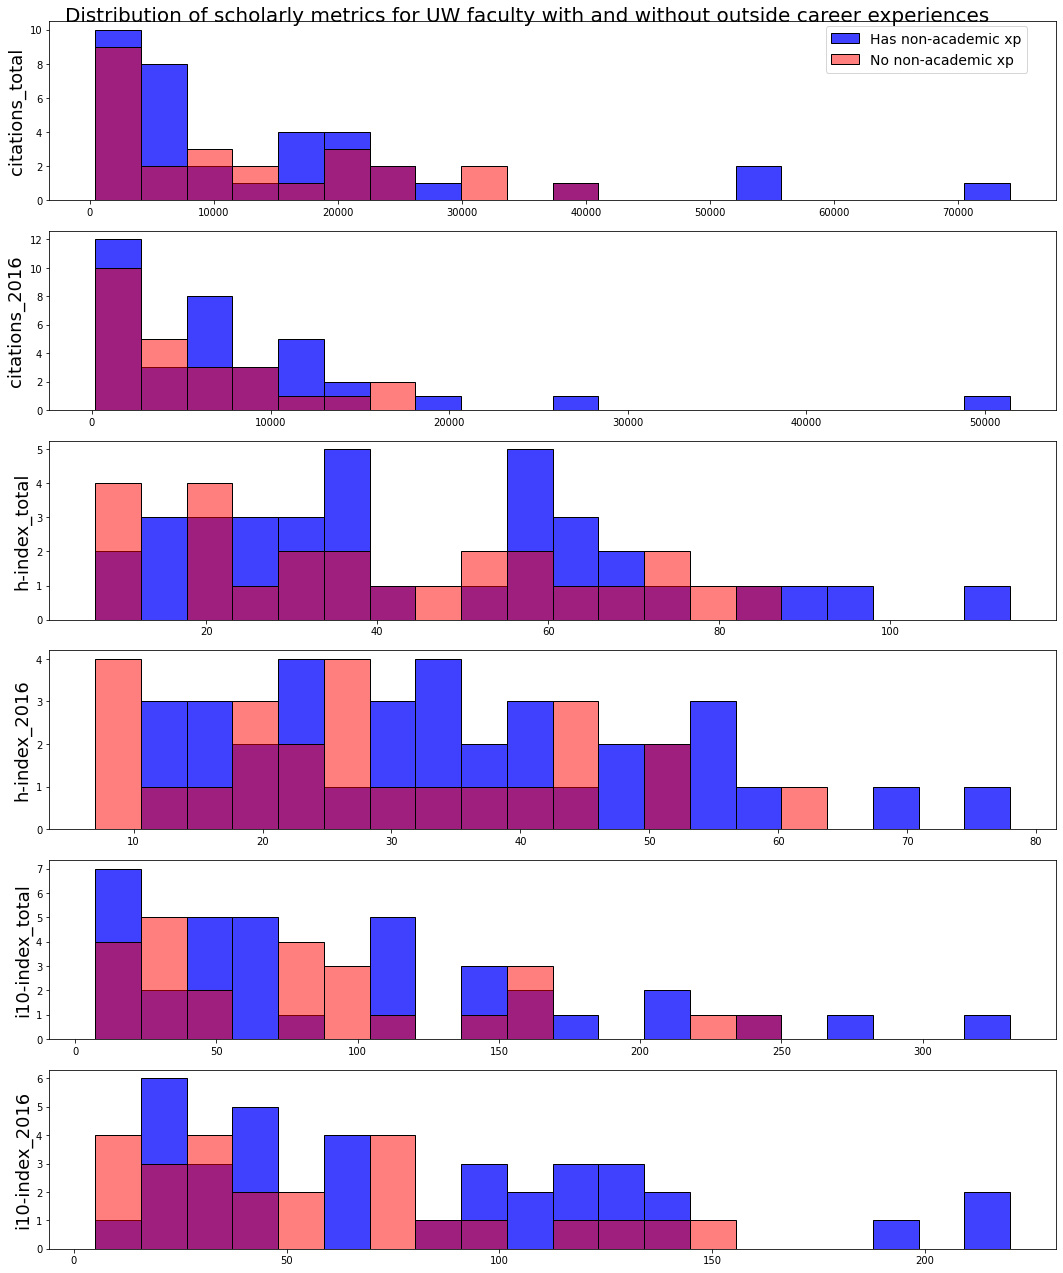

In [24]:
n  = 6 
fig, ax = plt.subplots(n)
plt.rc('axes', labelsize=18)
# sns.set_palette()
# sns.set_palette("flare", color_codes=True)
for i, col in enumerate(cols[:n]):
    a = scholarmeta[scholarmeta["nonacademic"]][col]
    b = scholarmeta[~scholarmeta["nonacademic"]][col]
    bins=np.histogram(np.hstack((a,b)), bins=20)[1]
    sns.histplot(a, ax=ax[i], label="Has non-academic xp", bins = bins, alpha=0.75, color="b")
    sns.histplot(b, ax=ax[i], label="No non-academic xp", bins = bins, alpha=0.5, color="r")
    # ax[i].set_xticks([])
    ax[i].set(ylabel=col, xlabel=None)
# fig.legend()
handles, labels = ax[i].get_legend_handles_labels()
fig.suptitle("Distribution of scholarly metrics for UW faculty with and without outside career experiences", fontsize=20)
fig.legend(handles, labels,loc='upper right', bbox_to_anchor=(.97, .97), fontsize=14)
fig.set_figheight(18)
fig.set_figwidth(15)
fig.tight_layout()
plt.savefig("metrics.png")

The small sample sizes prevent us from drawing any large conclusions, but the general interepretation of the above data is that it appears that those with non-academic experience fare comparatively better at recent metrics (the above three metrics over the last five years). There are a number of explanations for this, but one might be that those with non-academic experience are comparatively younger in our sample. Those without non-academic experience graduated 22 years ago on average, whereas those with non-academic experience graduated 13 years ago on average. 

As the tables show, those with non-academic experience average more citations. However, the graphs show that the difference in distribution is largely driven by a few outiers in the non-academic group. While it is not worth reading too deeply into outliers, it might make sense that the non-academic experience group would be right tailed: a stellar professor might be more likely to earn or have bandwidth for outside positions.  

In [25]:
# Get the years that a scholar was working
def workingyrs(row, i):
    yr = datetime(year=i, month=1, day=1).year
    x = nonacademic2[nonacademic2.id == row.name]
    for _, r in x.iterrows():
        if yr > r.year_start and yr <  r.year_end:
            return True
    return False

for i in range(2000, 2022):
    scholarmeta[f"working_{i}"] = scholarmeta.apply(workingyrs, args=(i,), axis=1)
    

In [26]:
for yr in range(2000, 2022):
    yrsarts = gsdf[gsdf.year == yr]
    workingscholars = scholarmeta[scholarmeta[f"working_{yr}"]].index
    workingarts = yrsarts[yrsarts["id"].isin(workingscholars)]
    if len(workingscholars):
        working_per_year = len(workingarts) / len(workingscholars)
    else:
        continue
    # print(f"working scholars articles per year ({yr}): {working_per_year}")
    yrsarts2 = yrsarts[~(yrsarts["id"].isin(workingscholars))]
    nonworkers = yrsarts2.id.unique()
    if len(nonworkers): 
        nonworking_per_year = len(yrsarts2) / len(nonworkers)
    else: 
        continue
    # print(f"non-working scholars articles per year ({yr}): {nonworking_per_year}")

    print(f"{yr}: Difference between workers and non-workers {working_per_year - nonworking_per_year} ")

    

2001: Difference between workers and non-workers -0.14814814814814792 
2002: Difference between workers and non-workers 0.17741935483870996 
2003: Difference between workers and non-workers -1.6875 
2004: Difference between workers and non-workers -1.229166666666667 
2005: Difference between workers and non-workers -2.083333333333333 
2006: Difference between workers and non-workers -3.342857142857143 
2007: Difference between workers and non-workers 0.6749999999999998 
2008: Difference between workers and non-workers 3.238095238095238 
2009: Difference between workers and non-workers 2.166666666666667 
2010: Difference between workers and non-workers 3.5777777777777775 
2011: Difference between workers and non-workers 0.2819148936170208 
2012: Difference between workers and non-workers 0.0625 
2013: Difference between workers and non-workers 1.1529411764705895 
2014: Difference between workers and non-workers 4.268518518518518 
2015: Difference between workers and non-workers 4.850340

For the last 13 years, faculty who held non-academic positions at the time on average produced more papers per person than faculty who were not working other jobs at the time. 

In [27]:
def beforexp(row):
    if not row["nonacademic"]:
        return False
    else:
        return (row['year'] < scholarmeta.loc[row['id']].first_xp_start)

In [28]:
def duringxp(row):
    # This is super slow but will do for now
    if not row["nonacademic"]:
        return False
    else:
        x = nonacademic2[nonacademic2.id == row["id"]]
        for _, r in x.iterrows():
            if (row['year'] > pd.to_datetime(r.date_start_asdt).year and row['year'] <  pd.to_datetime(r.date_end_asdt).year):
                return True
    return False



In [29]:
def afterxp(row):
    if (not row["nonacademic"] or row["duringxp"]):
        return False
    else:
        return row['year'] > scholarmeta.loc[row['id']].first_xp_end

In [30]:
gsdf["beforexp"] = gsdf.apply(beforexp, axis=1)
gsdf["duringxp"] = gsdf.apply(duringxp, axis=1)
gsdf["afterxp"] = gsdf.apply(afterxp, axis=1)

In [31]:
# scholars with a nonacademic expereince after graduation
gsnonac = gsdf[gsdf["nonacademic"]]
# scholars without a nonacademic expereince after graduation
gsdfac = gsdf[~gsdf["nonacademic"]]

In [32]:
# probably should filter for only articles after they've graduated from PhD
# or control for years since graduation in the future
b4group = gsdf[(gsdf["beforexp"]) & (gsdf.year > 2000)].groupby("year")
b4ppl = b4group.nunique().id
before = b4group.size() / b4ppl
before


year
2001.0     3.571429
2002.0     4.454545
2003.0     4.800000
2004.0     5.000000
2005.0     4.428571
            ...    
2014.0     6.777778
2015.0     9.142857
2016.0     9.333333
2017.0    10.600000
2018.0    10.000000
Length: 18, dtype: float64

In [33]:
aftergroup = gsdf[(gsdf["afterxp"]) & (gsdf.year > 2000)].groupby("year")
afterppl = aftergroup.nunique().id
after = aftergroup.size() / afterppl
after

year
2001.0    10.500000
2002.0     9.500000
2003.0    19.000000
2004.0    16.333333
2005.0    24.000000
            ...    
2017.0    13.888889
2018.0    15.454545
2019.0    10.818182
2020.0     8.555556
2021.0     9.388889
Length: 21, dtype: float64

In [34]:
pd.options.display.max_rows = 20
((aftergroup.size() / afterppl)- (b4group.size() / b4ppl) ).head(20)

year
2001.0     6.928571
2002.0     5.045455
2003.0    14.200000
2004.0    11.333333
2005.0    19.571429
2006.0    12.050000
2007.0    12.980769
2008.0    13.256410
2009.0     8.000000
2010.0    13.666667
2011.0     5.500000
2012.0     9.875000
2013.0    16.750000
2014.0     8.000000
2015.0     4.357143
2016.0     4.222222
2017.0     3.288889
2018.0     5.454545
2019.0          NaN
2020.0          NaN
dtype: float64

In [35]:
duringgroup = gsnonac[(gsnonac["duringxp"]) & (gsnonac.year > 2000)].groupby("year")
duringppl = duringgroup.nunique().id
during = duringgroup.size() / duringppl
during


year
2002.0     4.000000
2003.0     9.000000
2004.0     8.000000
2005.0     5.500000
2006.0     3.750000
2007.0     7.000000
2008.0    11.500000
2009.0    10.000000
2010.0    13.000000
2011.0    11.666667
2012.0    10.500000
2013.0     9.800000
2014.0    12.250000
2015.0    14.666667
2016.0    14.000000
2017.0    11.625000
2018.0    10.625000
2019.0    19.000000
2020.0    25.230769
dtype: float64

In [36]:
b4duringafter = pd.DataFrame([before, during, after], )
b4duringafter = b4duringafter.T
b4duringafter.columns = ["before", "during", "after"]
b4duringafter

,before,during,after
year,,,
2001.0,3.571429,NaN,10.500000
2002.0,4.454545,4.000000,9.500000
2003.0,4.800000,9.000000,19.000000
2004.0,5.000000,8.000000,16.333333
2005.0,4.428571,5.500000,24.000000
...,...,...,...
2017.0,10.600000,11.625000,13.888889
2018.0,10.000000,10.625000,15.454545
2019.0,NaN,19.000000,10.818182


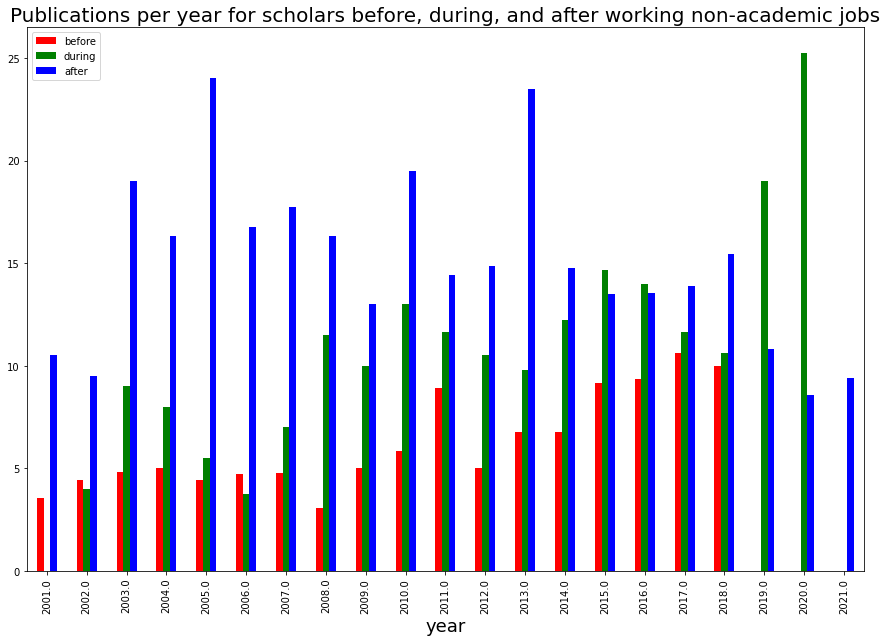

In [37]:
ax = b4duringafter.plot.bar(
    figsize=(15,10), 
    color = ["r", "g", "b"],
    # title=
    )
ax.set_title("Publications per year for scholars before, during, and after working non-academic jobs", fontsize=20)
# plt.show()
plt.savefig("pub_per_year.png")

While the data is skewed because we only count current faculty, it appears that scholars who had finished a non-academic experience published more on average than scholars who had yet to undertake a non-academic experience.
However, we have not controlled for the age of the faculty member or other factors, so this currently is a correlation rather than a substantial finding (i.e. we can hypothesize about why this might be the case but it does not necessarily mean that doing non-academic work makes a person a better scholar).

In [38]:
gsdf[gsdf["afterxp"]].cited_by.describe()

count     1401.000000
mean        68.624554
std        329.820480
min          1.000000
25%          4.000000
50%         15.000000
75%         52.000000
max      11071.000000
Name: cited_by, dtype: float64

In [39]:
gsdf[gsdf["beforexp"]].cited_by.describe()

count      864.000000
mean       152.394676
std        485.717083
min          1.000000
25%         13.000000
50%         48.500000
75%        124.250000
max      11605.000000
Name: cited_by, dtype: float64

In [40]:
gsdf[gsdf["duringxp"]].cited_by.describe()


count     1130.000000
mean       108.078761
std        651.805082
min          1.000000
25%          7.000000
50%         23.000000
75%         69.000000
max      17472.000000
Name: cited_by, dtype: float64

Articles published before a non-academic experience are cited more often, but that could be due in part to the fact that these articles on average have been around longer:

In [41]:
gsdf[gsdf["beforexp"]].year.describe()


count     924.000000
mean     2009.853896
std         4.751378
min      2001.000000
25%      2006.000000
50%      2010.000000
75%      2014.000000
max      2018.000000
Name: year, dtype: float64

In [42]:
gsdf[gsdf["afterxp"]].year.describe()


count    1964.000000
mean     2013.423116
std         5.300323
min      2001.000000
25%      2010.000000
50%      2014.000000
75%      2018.000000
max      2021.000000
Name: year, dtype: float64

In [43]:
gsdf[gsdf["duringxp"]].year.describe()


count    1332.000000
mean     2015.753003
std         4.506422
min      2002.000000
25%      2013.000000
50%      2017.000000
75%      2019.000000
max      2020.000000
Name: year, dtype: float64